# 声场物理信息神经网络  
把仿真结果整个放到PINNs框架中训练,为了展示无处理时框架对于数据的处理能力。  
抛物方程结果含有距离有关因素影响，所以考虑**KRAKEN**作为最简单数据来源。  
**控制方程**：
$$p_{rr} + p_{zz} + k^2p=\delta(z-z_0)$$
**边界条件**：
$$p(r,z=0)=0,\frac{\partial p}{\partial z}(r,z=H)=0$$
**初始条件**:
$$p(r=0,z)=S(z)\delta(z-z0)$$

In [58]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import sciann as sn
from sciann import Variable, Functional, Data, SciModel, PDE, Parameter
import tensorflow.keras.callbacks as callbacks
from sciann.utils.math import diff, cos, sqrt, sin, sign
import scipy.io
import time
import os
import tensorflow as tf
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 数据集设置：  
  数据集来自kraken算例，原输入文件在./Data中。  
  该算例是375m浅海液态波导，计算200Hz条件下距离100km的声场相关干涉结果。密度设定为恒定值，无吸收系数，不考虑海底横波。  
  **Data summary**：    
  * *INPUT*  
    >* freq=const  **name: Freq, also in OMEGA**  
    >* r           **name: r, r_forTrain, RR**  
    >* z           **name: z, z_forTrain, ZZ**  
    >* c           **name: c_star, c_forTrain**
    
  * *OUTPUT*  
    >* pressure(real-part)  **name: Rp_forTrain**
    >* pressure(imag-part)  **name: Im_forTrain**
  
  * *BOUNDARY*
    >* Perfectly Free Boundary(**Dirichlet BC**)[Seaface]
    >* Perfectly Rigid Boundary(**Neumann BC**)[SeaBed]
    >* Acoustic Half-space Conditions(**Robin BC**)

In [59]:
def data_tmp(num=300000, random=True):
    # load data
    data = scipy.io.loadmat('Data/kraken_200Hz_pressure.mat')
    Re_P_star = data['RP'][:, :] # 声压实部
    Im_P_star = data['IP'][:, :] # 声压虚部
    c_star = data['SSP'][:, :] # 水中声速剖面[z,c]
    Freq = 200 # Hz
    SeaH = data['SeaBoundary'][:, 0] # 海底界面深度，m
    SeaP = data['SeaBoundary'][:, 1] # 海底界面纵波声速，m/s
    PI = np.pi 
    # array Range and Depth
    R = data['rt'] # Pos.r.rt
    Z = data['zt'] # Pos.r.zt
    # grids number of range&depth
    nr = R.shape[0] 
    nz = Z.shape[0]
    print(nr,nz)
    RR, ZZ = np.meshgrid(R, Z)
    OMEGA = 2*PI*Freq
    c_star = np.repeat(c_star.T, nr, axis=1)
    # Pick random data
    if num > (nr)*(nz) and random:
        num = int((nr)*(nz)*0.8)
        
    if random:
        idx = np.random.choice((nr)*(nz), num, replace=False)
    else:
        idx = np.arange(0, (nr)*(nz))
        nr = RR
        nz = ZZ
    
    # need flatten for ANN
    r_forTrain = RR.flatten()[idx, None]
    z_forTrain = ZZ.flatten()[idx, None]
    c_forTrain = c_star.flatten()[idx, None]
    Rp_forTrain = Re_P_star.flatten()[idx, None]
    Ip_forTrain = Im_P_star.flatten()[idx, None]
    return r_forTrain, z_forTrain, c_forTrain, OMEGA, Rp_forTrain, Ip_forTrain, nr, nz, SeaH, SeaP

In [ ]:
if __name__ == "__main__":
    # prepare data
    r_train, z_train, c_train,Omega, p_real_train, p_imag_train, nr, nz, SeaH, SeaP = data_tmp()
     # BatchNormalization
    # scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaler = LogStdScaler().fit(yy.reshape(-1, 1))
#     y_data = scaler.transform(yy.reshape(-1, 1))

    # Flag
    IsTrain = True
    
    # Variables and Fields
    r = Variable("r", dtype='float64')
    z = Variable("z", dtype='float64')
    c = Variable("c", dtype='float64')

    layers = 4*[60]
    p_real,p_imag = Functional(["p_real","p_imag"],[r, z, c], layers, 'tanh')
    # Define constraints, pde split into real- and image- valued
    P1 = Data(p_real)
    P2 = Data(p_imag)
    C1 = PDE(diff(p_real, r, order=2) + diff(p_real, z, order=2) + (Omega/c)**2*p_real)
    C2 = PDE(diff(p_imag, r, order=2) + diff(p_imag, z, order=2) + (Omega/c)**2*p_imag)
    
    TOL = 0.001
    # Neumann boundary B1 (seaface:z=0)
    N1 = sn.rename((1 - sign(z - (0 + TOL))) * (p_real), 'N1')
    N2 = sn.rename((1 - sign(z - (0 + TOL))) * (p_imag), 'N2')
    
    # Dirichlet boundary B2 (seabed:z=376)
    D1 = sn.rename((1 - sign(z - (SeaH + TOL))) * diff( p_real, z, order=1 ), 'D1')
    D2 = sn.rename((1 - sign(z - (SeaH + TOL))) * diff( p_imag, z, order=1 ), 'D2')
    
    # Initial boundary B0 (source:r=0)
#     I1 = (1 - sign(r - TOL)) * delta(z-z0)
    
    input = [r, z, c]
    input_data = [r_train, z_train, c_train]
#     cons = [P1, P2, c1, c2, N1, N2, D1, D2]
#     cons_data = [p_real_train, p_imag_train, 8*'zeros']
    cons = [P1, P2, C1, C2, N1, N2, D1, D2]
    cons_data = [p_real_train, p_imag_train, 'zeros','zeros','zeros','zeros','zeros','zeros']
    model = SciModel(
        input,
        cons,
        loss_func="mse",
        optimizer='Adam'
    )
    # callbacks
    current_path = os.path.abspath('')
    checkpoint_filepath = str(os.path.join(current_path, 'callbacks/helmholtz/full_KRAKEN_dr10_dz2.ckpt'))
    save_path = str(os.path.join(current_path, 'model/fullPINNtanh_mse_Adam_NTK_4x60.hdf5'))
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='auto',
        save_best_only=True,
        learning_rate=1e-6
    )
    if IsTrain:
        t = time.time()
        history = model.train(
            input_data,
            cons_data,
            epochs=1000,
            batch_size=256,
            adaptive_weights={"method":'NTK', 'freq':100, 'use_score':True},
            shuffle=True,
            learning_rate=0.001,
            reduce_lr_after=100,
            stop_loss_value=1e-8
#             callbacks=[model_checkpoint_callback]
        )
        t = time.time() - t
        model.save_weights(save_path)

        fig1 = plt.figure(1)
        plt.semilogy(history.history['loss'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.savefig('./figures/fig5_loss_history.png')

    else:
        model.load_weights(save_path)
    

1001 376

Total samples: 300000 
Batch size: 256 
Total batches: 1172 

219.5768404006958

+ adaptive_weights at epoch 1: [0.10140135801390458, 0.1001299118828451, 0.10337084295598713, 0.10032253830308148, 3.114364508972632, 4.271500040901231, 0.10810324481528473, 0.10080755415503369]
Epoch 1/1000
1172/1172 [==============================] - 47s 40ms/step - loss: 3.5267e-04 - p_real_loss: 8.0577e-04 - p_imag_loss: 9.0995e-04 - add_16_loss: 4.1969e-04 - add_18_loss: 4.7314e-04 - N1_loss: 9.1795e-06 - N2_loss: 1.4096e-05 - D1_loss: 1.3817e-06 - D2_loss: 5.4385e-07
Epoch 2/1000
1172/1172 [==============================] - 40s 34ms/step - loss: 5.1488e-05 - p_real_loss: 1.8580e-04 - p_imag_loss: 8.9493e-05 - add_16_loss: 9.6464e-05 - add_18_loss: 4.6335e-05 - N1_loss: 1.4767e-06 - N2_loss: 1.0371e-06 - D1_loss: 1.5978e-07 - D2_loss: 2.0999e-07 3s - loss: 2.8293e-05 - p_real_loss: 7.1268e-05 - p_imag_loss: 7.1816e-05 - add_16_loss: 3.6796e-05 - add_18_loss: 3.7108e-05 - N1_loss: 7.2843e-07 

1001 376


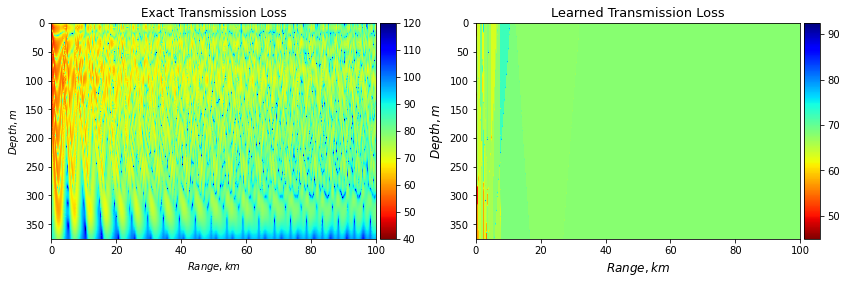

In [36]:
    # eval data
    data = scipy.io.loadmat('Data/kraken_200Hz_pressure.mat')
    Re_P_star = data['RP'][:, :] # 声压实部
    Im_P_star = data['IP'][:, :] # 声压虚部
    c_star = data['SSP'][:, :] # 水中声速剖面[z,c]
    Freq = 200 # Hz
    SeaH = data['SeaBoundary'][:, 0] # 海底界面深度，m
    SeaP = data['SeaBoundary'][:, 1] # 海底界面纵波声速，m/s
    PI = np.pi 
    # array Range and Depth
    R = data['rt'] # Pos.r.rt
    Z = data['zt'] # Pos.r.zt
    # grids number of range&depth
    nr = R.shape[0] 
    nz = Z.shape[0]
    print(nr,nz)
    RR, ZZ = np.meshgrid(R, Z)
    OMEGA = 2*PI*Freq
    c_star = np.repeat(c_star.T, nr, axis=1)
    
    # data for eval
    r_eval = RR.flatten()
    z_eval = ZZ.flatten()
    c_eval = c_star.flatten()
    RP_eval = Re_P_star.flatten()
    IP_eval = Im_P_star.flatten()
    
    # exact solution
    ReP_exact = RP_eval.reshape(nz, nr)
    ImP_exact = IP_eval.reshape(nz, nr)
    TL = -20 * np.log10(np.sqrt(ReP_exact ** 2 + ImP_exact ** 2))
    fig = plt.figure(1)
    gs0 = gridspec.GridSpec(1, 4)
    gs0.update(top=1 - 0.1, bottom=0.15, left=0.12, right=1.9, wspace=0.6)
    ax = plt.subplot(gs0[:, 0:2])
    h = ax.pcolormesh(RR / 1000, ZZ, TL, cmap='jet_r', shading='nearest', vmin=40, vmax=120)
    ax.invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(h, cax=cax)
    ax.set_xlabel('$Range,km$')
    ax.set_ylabel('$Depth,m$')
    ax.set_title('Exact Transmission Loss', fontsize=12)

    # pred solution
    eval_input = [r_eval, z_eval, c_eval]
    p_real_pred = p_real.eval(model, eval_input).reshape(nz, nr)
    p_imag_pred = p_imag.eval(model, eval_input).reshape(nz, nr)
    tl_pred = -20 * np.log10(np.sqrt(p_real_pred ** 2 + p_imag_pred ** 2))
    ax = plt.subplot(gs0[:, 2:4])
    h = ax.pcolormesh(RR / 1000, ZZ, tl_pred, cmap='jet_r', shading='nearest')
    ax.invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(h, cax=cax)
    ax.set_xlabel('$Range,km$', fontsize=12)
    ax.set_ylabel('$Depth,m$', fontsize=12)
    ax.set_title('Learned Transmission Loss', fontsize=13)
    plt.show()
#     # save
#     plt.savefig('./figures/fig5-1.png', dpi=300, bbox_inches = 'tight')

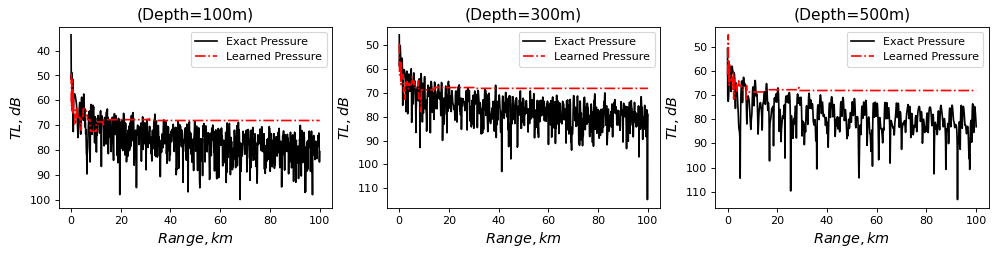

In [55]:
    fig = plt.figure(figsize=(15, 3), dpi=80)
    # Num of Depth, with dz=2m
    ax1 = plt.subplot(1, 3, 1)
    d = 50
    h = ax1.plot(RR[d, :] / 1000,TL[d, :], 'k-',linewidth=1.5, label='Exact Pressure')
    # pred solution
    h = ax1.plot(RR[d, :] / 1000, tl_pred[d, :], 'r-.', linewidth=1.5, label='Learned Pressure')
    ax1.invert_yaxis()
    ax1.set_xlabel('$Range,km$',fontsize=13)
    ax1.set_ylabel('$TL,dB$',fontsize=13)
    ax1.set_title(('(Depth='+str(d*2)+'m)'), fontsize=14)
    plt.legend()
    ax2 = plt.subplot(1, 3, 2)
    d = 150
    h = ax2.plot(RR[d, :] / 1000,TL[d, :], 'k-',linewidth=1.5, label='Exact Pressure')
    # pred solution
    h = ax2.plot(RR[d, :] / 1000, tl_pred[d, :], 'r-.', linewidth=1.5, label='Learned Pressure')
    ax2.invert_yaxis()
    ax2.set_xlabel('$Range,km$',fontsize=13)
    ax2.set_ylabel('$TL,dB$',fontsize=13)
    ax2.set_title(('(Depth='+str(d*2)+'m)'), fontsize=14)
    plt.legend()
    ax3 = plt.subplot(1, 3, 3)
    d = 250
    h = ax3.plot(RR[d, :] / 1000,TL[d, :], 'k-',linewidth=1.5, label='Exact Pressure')
    # pred solution
    h = ax3.plot(RR[d, :] / 1000, tl_pred[d, :], 'r-.', linewidth=1.5, label='Learned Pressure')
    ax3.invert_yaxis()
    ax3.set_xlabel('$Range,km$',fontsize=13)
    ax3.set_ylabel('$TL,dB$',fontsize=13)
    ax3.set_title(('(Depth='+str(d*2)+'m)'), fontsize=14)
    plt.legend()
    plt.show()
#     plt.savefig('./figures/fig5-2.png', dpi=300, bbox_inches = 'tight')

In [57]:
print(nr*nz*0.8)

301100.8
